# Difference Map

This notebook explores the calculations needed to plot the Difference Map in the Project Dashboard  
**Create multiple scenarios:** create some dummy scenario data for comparisons  
**Difference Map function:** make the calculations needed for the Difference Map.  
**Plot Difference map:** example of visualization with bivariate map

The assumption is that each planning unit should fall into just one category.  

In [8]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run marxan_utils.ipynb

## Create multiple scenarios

In [ ]:
# Scenario 1
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario1'
Input,pu,spec,puvsp,bound = validate_all_files(MARXAN_FOLDER,'input.dat')
execute_marxan(MARXAN_FOLDER)
#BLM 0.3, n = 100

In [ ]:
# Scenario 2
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario2'
MARXAN_INPUTDATA = 'input.dat'
userInputFile,pu,spec,puvsp,bound = validate_all_files(MARXAN_FOLDER,MARXAN_INPUTDATA)

### Modify BLM
userInputFile.BLM = 10
userInputFile.NUMREPS = 30
userInputFile_df = pd.DataFrame.from_dict(userInputFile.__dict__, orient='index')
userInputFile_df= userInputFile_df.drop('BLOCKDEFNAME')
CreateFileFromDF(f'{MARXAN_FOLDER}/{MARXAN_INPUTDATA}',userInputFile_df,inputDatFile)

### Modify SPF and prop
spec.prop =0.5
spec.spf = 1
spec.head()
CreateFileFromDF(f'{MARXAN_FOLDER}/{Input.INPUTDIR}/{Input.SPECNAME}', spec, conservationFeature)

### Run Marxan
execute_marxan(MARXAN_FOLDER)

In [ ]:
# Scenario 3
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario3'
MARXAN_INPUTDATA = 'input.dat'

userInputFile= readInput(SCEN1_PATH,MARXAN_INPUTDATA)
pu= validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, planningUnits)
spec= validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, conservationFeature)

### Modify BLM
userInputFile.BLM = 0.01
userInputFile.NUMREPS = 100
userInputFile_df = pd.DataFrame.from_dict(userInputFile.__dict__, orient='index')
userInputFile_df= userInputFile_df.drop('BLOCKDEFNAME')
CreateFileFromDF(f'{MARXAN_FOLDER}/{MARXAN_INPUTDATA}',userInputFile_df,inputDatFile)

### Modify SPF and prop
spec.prop =0.2
spec.spf = 1
spec.head()
CreateFileFromDF(f'{MARXAN_FOLDER}/{userInputFile.INPUTDIR}/{userInputFile.SPECNAME}', spec, conservationFeature)

### Lock-in and Lock-out some PUs
import random

randomlist = []
for i in range(0,int(0.3*len(pu))):
    n = random.randrange(2,3,1)
    randomlist.append(n)

l = [0] * (len(pu) - len(randomlist))
randomlist.extend(l)
random.shuffle(randomlist)
len(randomlist)

pu['status'] = randomlist
CreateFileFromDF(f'{MARXAN_FOLDER}/{userInputFile.INPUTDIR}/{userInputFile.PUNAME}',pu,planningUnits)

### Run Marxan
execute_marxan(MARXAN_FOLDER)

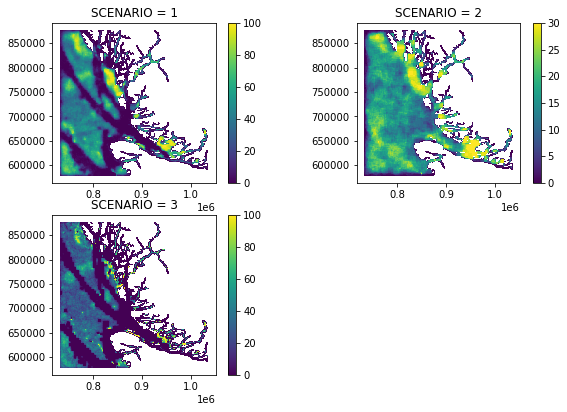

In [2]:
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario'
scenarios = ['1','2','3']
fig = plt.figure(figsize=(10,10))

for idx, sol in enumerate(scenarios):
    axn = fig.add_subplot(321+idx)
    solution = pd.read_csv(f"{MARXAN_FOLDER}{sol}/output/output_ssoln.csv") #freq
    pu_area = gpd.read_file(f'{MARXAN_FOLDER}{sol}/pu/pulayer.shp')
    solution_grid = pu_area.merge(solution,left_on='PUID',right_on = 'planning_unit',how='inner')
    solution_grid.plot(ax=axn,column='number', legend=True)
    axn.set_title(f'SCENARIO = {sol}')

### Difference Map function (update 15th June, with Bvariate Map)
Categories: 
+ Never
+ Always
+ Bivariate cloropleth (each Scenario divided in 4 classes of equal interval 0-0.25-0.5-0.75-1)

Follow this example for [bivariate cloroplepth](https://github.com/zorzalerrante/mapas_censo_2017/blob/master/Coropletas%20Bivariable.ipynb)

In [4]:
import spectra
import mapclassify
import shapely
import matplotlib.patheffects as path_effects
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
import seaborn as sns
%run marxan_utils.ipynb

In [2]:
## validating files will depend on needs of the DB
## Output will depend on the needs of the DB (now ouputing as DF, but could be a dict {pu:category})

def diffMap_bivariate(SCEN1_PATH: str,SCEN2_PATH: str, show_count: bool)-> dict:
# 1. Read files (input.dat, pu.dat, pu_grid)
    MARXAN_INPUTDATA = 'input.dat'
    # Input files
    input1 = readInput(SCEN1_PATH,MARXAN_INPUTDATA)
    input2 = readInput(SCEN2_PATH,MARXAN_INPUTDATA)
    
    ## Frequency of solutions output file
    s1 = validateFile(SCEN1_PATH,MARXAN_INPUTDATA, OutputSsoln)
    s2 = validateFile(SCEN2_PATH,MARXAN_INPUTDATA, OutputSsoln)

    ## Number of runs
    n1 = int(input1.NUMREPS)
    n2 = int(input2.NUMREPS)
    
# 2. Rename fields and merge with grid 
    # freq = the total number of times a pu has been selected in all solutions
    diff= s1.rename(columns={'number':'freq1'})
    diff['freq2'] = s2.number

    # rel_freq = freq/number of solutions (different scenarios may have different solution number)
    diff['rel_freq1'] = round(diff.freq1/n1,2)
    diff['rel_freq2'] = round(diff.freq2/n2,2)

# 3. Assign categories
    # Never selected in S1 & S2
    never = list(diff[(diff['rel_freq1'] == 0)   & (diff['rel_freq2'] == 0)].planning_unit.values)

    # Always in S1 & S2
    always = list(diff[(diff['rel_freq1'] == 1) & (diff['rel_freq2'] == 1)].planning_unit.values)
    
    # create dict of categories
    categories = {'never': never,
                  'always':always}
    
    diff['category']= 'both'
    for key in categories.keys():
        diff.loc[diff['planning_unit'].isin(categories[key]),'category'] = key
    
    return diff

In [5]:
SCEN1_PATH = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario2'
SCEN2_PATH = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario1'
GRID_PATH = f'{SCEN1_PATH}/pu/pulayer.shp'
diff = diffMap_bivariate(SCEN1_PATH,SCEN2_PATH, show_count =True)

In [6]:
diff

,planning_unit,freq1,freq2,rel_freq1,rel_freq2,category
0,12178,0,0,0.0,0.00,never
1,12177,0,0,0.0,0.00,never
2,12176,0,0,0.0,0.00,never
3,12175,0,7,0.0,0.07,both
4,12174,0,0,0.0,0.00,never
...,...,...,...,...,...,...
12173,5,0,15,0.0,0.15,both
12174,4,0,14,0.0,0.14,both
12175,3,0,11,0.0,0.11,both
12176,2,0,7,0.0,0.07,both


In [7]:
pu_grid = gpd.read_file(f'{GRID_PATH}')

In [8]:
diff = pu_grid[['PUID','geometry']].merge(diff,left_on='PUID',right_on ='planning_unit',how='inner')

In [9]:
diff.head()

,PUID,geometry,planning_unit,freq1,freq2,rel_freq1,rel_freq2,category
0,1,"POLYGON ((732060.000 578650.001, 732060.000 58...",1,0,4,0.0,0.04,both
1,2,"POLYGON ((734060.000 578650.001, 734060.000 58...",2,0,7,0.0,0.07,both
2,3,"POLYGON ((736060.000 578650.001, 736060.000 58...",3,0,11,0.0,0.11,both
3,4,"POLYGON ((738060.000 578650.001, 738060.000 58...",4,0,14,0.0,0.14,both
4,5,"POLYGON ((740060.000 578650.001, 740060.000 58...",5,0,15,0.0,0.15,both


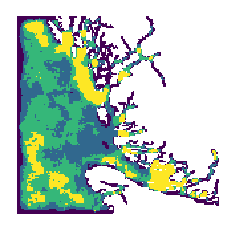

In [10]:
ax = diff.plot(column='rel_freq1', edgecolor='none', scheme='fisherjenks', k=4)
ax.set_axis_off()

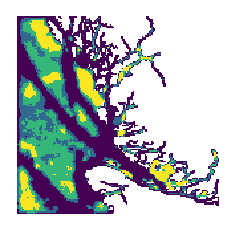

In [11]:
ax = diff.plot(column='rel_freq2', edgecolor='none', scheme='fisherjenks', k=4)
ax.set_axis_off()

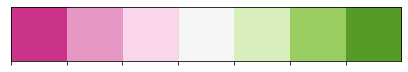

In [12]:
## Create palettes
n_categories = 4
full_palette = sns.color_palette('PiYG', n_colors=(n_categories - 1) * 2 + 1)
sns.palplot(full_palette)

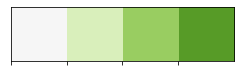

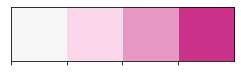

In [13]:
cmap_x = full_palette[n_categories - 1:]
sns.palplot(cmap_x)
cmap_y = list(reversed(full_palette))[n_categories - 1:]
sns.palplot(cmap_y)

In [14]:
scen1_bin = mapclassify.EqualInterval(diff['rel_freq1'], k=n_categories)
scen1_bin

EqualInterval       

  Interval     Count
--------------------
[0.00, 0.25] |  2518
(0.25, 0.50] |  3860
(0.50, 0.75] |  4025
(0.75, 1.00] |  1775

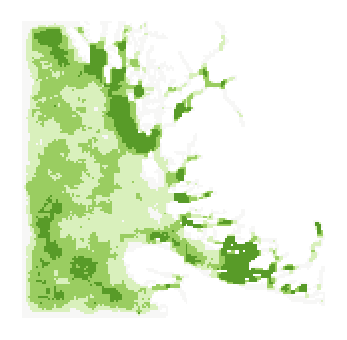

In [15]:
# creamos la figura
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# por cada categoría dibujamos en la figura
for i in range(n_categories):
    areas_in_this_category = np.where(scen1_bin.yb == i)[0]
    # usamos el método rgb2hex para que matplotlib reconozca el color que utilizamos
    diff.iloc[areas_in_this_category].plot(color=rgb2hex(cmap_x[i]), ax=ax, edgecolor='none')
    
# sacamos elementos decorativos del gráfico
ax.set_axis_off()

In [16]:
scen2_bin = mapclassify.EqualInterval(diff['rel_freq2'], k=n_categories)
scen2_bin

EqualInterval       

  Interval     Count
--------------------
[0.00, 0.25] |  6402
(0.25, 0.50] |  3244
(0.50, 0.75] |  1868
(0.75, 1.00] |   664

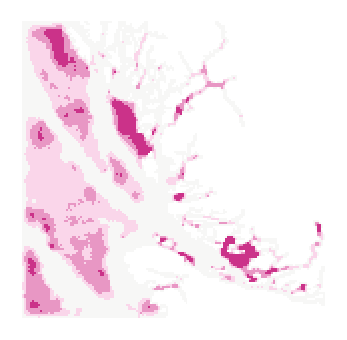

In [17]:
# creamos la figura
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# por cada categoría dibujamos en la figura
for i in range(n_categories):
    areas_in_this_category = np.where(scen2_bin.yb == i)[0]
    # usamos el método rgb2hex para que matplotlib reconozca el color que utilizamos
    diff.iloc[areas_in_this_category].plot(color=rgb2hex(cmap_y[i]), ax=ax, edgecolor='none')
    
# sacamos elementos decorativos del gráfico
ax.set_axis_off()

In [18]:
### Combine both palettes
cmap_xy = []
bivariate_palette = {}

for j in range(n_categories):
    for i in range(n_categories):
        x = spectra.rgb(*cmap_x[i][0:3])
        y = spectra.rgb(*cmap_y[j][0:3])
        
        if i == j and i == 0:
            cmap_xy.append(x.darken(1.5).rgb)
        elif i == 0:
            cmap_xy.append(y.rgb)
        elif j == 0:
            cmap_xy.append(x.rgb)
        else: 
            blended = x.blend(y, ratio=0.5)
            
            if i == j:
                blended = blended.saturate(7.5 * (i + 1))
            else:
                blended = blended.saturate(4.5 * (i + 1))
                
            cmap_xy.append(blended.rgb)
            
        bivariate_palette[(i, j)] = rgb2hex(cmap_xy[-1])
            
cmap_xy = np.array(cmap_xy).reshape(n_categories, n_categories, 3)

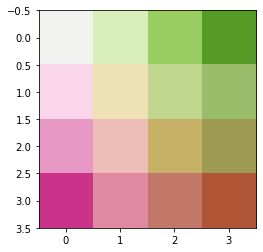

In [19]:
plt.imshow(cmap_xy)

In [20]:
bivariate_palette

{(0, 0): '#f2f3f2',
 (1, 0): '#d9f0bc',
 (2, 0): '#9acd61',
 (3, 0): '#589b28',
 (0, 1): '#fad6ea',
 (1, 1): '#efe3b6',
 (2, 1): '#c1d58d',
 (3, 1): '#9abe6a',
 (0, 2): '#e897c4',
 (1, 2): '#efbeb8',
 (2, 2): '#c6b268',
 (3, 2): '#9e9b55',
 (0, 3): '#cb3289',
 (1, 3): '#df89a3',
 (2, 3): '#c37768',
 (3, 3): '#b15537'}

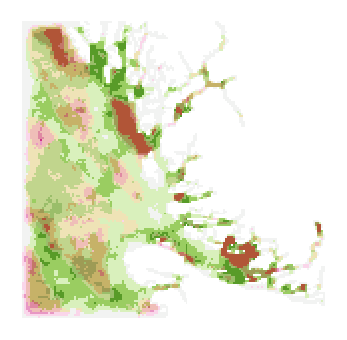

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(n_categories):
    for j in range(n_categories):
        areas_in_this_category = set(np.where(scen1_bin.yb == i)[0]) & set(np.where(scen2_bin.yb == j)[0])
        diff.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(i, j)], ax=ax, edgecolor='none')
    
ax.set_axis_off()

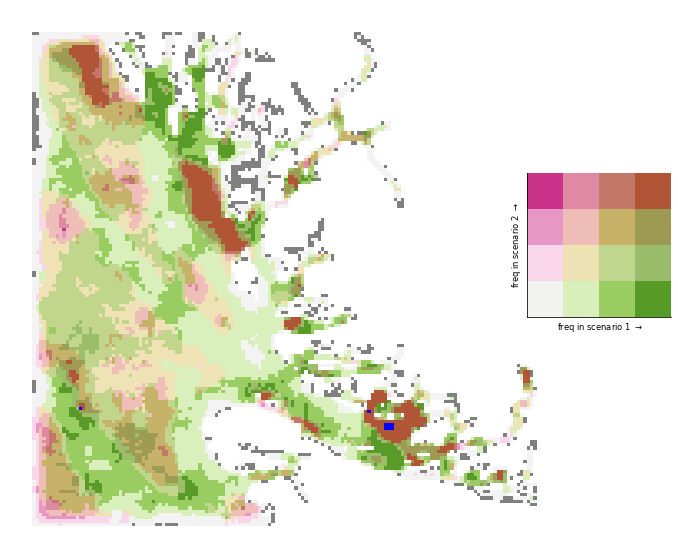

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for i in range(n_categories):
    for j in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        areas_in_this_category = set(np.where(scen1_bin.yb == i)[0]) & set(np.where(scen2_bin.yb == j)[0])
        diff.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(i, j)], ax=ax, edgecolor='none')

diff[diff['category']=='always'].plot(color='blue', ax=ax, edgecolor='none') ### add 1-1
diff[diff['category']=='never'].plot(color='gray', ax=ax, edgecolor='none') ### add 0-0
        
ax.set_axis_off()

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.85, .45, .2, .2], facecolor='y')
a.imshow(cmap_xy, origin='lower')
a.set_xlabel('freq in scenario 1 $\\rightarrow$', fontsize='small')
a.set_ylabel('freq in scenario 2 $\\rightarrow$', fontsize='small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)

## Difference Map Function (Old - with many categories)
[Reference paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002586)

#### Categories:
- never : Never selected in any of the scenarios
- always : Always selected in both scenarios (can include locked in areas in both scenarios)
- S1_always : Always selected only in S1 (can include locked in areas in S1)
- S2_always : Always selected only in S2 (can include locked in areas in S2)
- S1_only: Only selected in S1 (excluding pus already in *always* or *S1_always*. This can be representd as frequency on map insted of one color to highlight areas that are selected moreoften)
- S2_only: Only selected in S2 (excluding pus already in *always* or *S1_always*. This can be representd as frequency on map insted of one color to highlight areas that are selected moreoften)
- both_comparable: PUs selected in both scenarios with comparable frequency [the absolute difference of the relative frequencies is below 10% (relfreqS1 - relfreqS2 < 0.1)]
- both_higherS1: PUs selected in both scenarios BUT with higher frequency in S1 [the difference of the relative frequencies is above 10% (relfreqS1 - relfreqS2 > 0.1)]
- both_higherS2: PUs selected in both scenarios BUT with higher frequency in S2 [the difference of the relative frequencies is above 10% (relfreqS1 - relfreqS2 < -0.1)]

In [58]:
## validating files will depend on needs of the DB
## Output will depend on the needs of the DB (now ouputing as DF, but could be a dict {pu:category})

def diffMap(SCEN1_PATH: str,SCEN2_PATH: str, show_count: bool)-> dict:
# 1. Read files (input.dat, pu.dat, pu_grid)
    MARXAN_INPUTDATA = 'input.dat'
    # Input files
    input1 = readInput(SCEN1_PATH,MARXAN_INPUTDATA)
    input2 = readInput(SCEN2_PATH,MARXAN_INPUTDATA)
    
    #pu.dat files
    pu1 = validateFile(SCEN1_PATH,MARXAN_INPUTDATA, planningUnits)
    pu2 = validateFile(SCEN2_PATH,MARXAN_INPUTDATA, planningUnits)
    
    ## Frequency of solutions output file
    s1 = validateFile(SCEN1_PATH,MARXAN_INPUTDATA, OutputSsoln)
    s2 = validateFile(SCEN2_PATH,MARXAN_INPUTDATA, OutputSsoln)

    ## Number of runs
    n1 = int(input1.NUMREPS)
    n2 = int(input2.NUMREPS)
    
# 2. Rename fields and merge with grid 
    # freq = the total number of times a pu has been selected in all solutions
    diff= s1.rename(columns={'number':'freq1'})
    diff['freq2'] = s2.number

    # rel_freq = freq/number of solutions (different scenarios may have different solution number)
    diff['rel_freq1'] = round(diff.freq1/n1,2)
    diff['rel_freq2'] = round(diff.freq2/n2,2)

    # diff = selection of scenario 1 - scenario 2
    # dif_abs = absolute difference 
    diff['diff'] = diff.rel_freq1  - diff.rel_freq2
    diff['diff_abs'] = diff['diff'].abs()

    # pu.dat get status
    pu1 = pu1.rename(columns={'status':'status1'})
    pu1['status2'] = pu2.status

# 3. Assign categories
    # Never selected in S1 & S2
    never = list(diff[(diff['rel_freq1'] == 0)   & (diff['rel_freq2'] == 0)].planning_unit.values)

    # Locked-in /Always
    # status 2 in pu.dat should give rel_freq=1, but that is not the case. TO DO: understand why
    lock1 = list(diff[(diff['rel_freq1'] == 1)].planning_unit.values)
    lock2 = list(diff[(diff['rel_freq2'] == 1)].planning_unit.values)
    always = list(set(lock1) & set(lock2)) # Always selected in both
    S1_always = list(set(lock1) - set(always)) # always selected in S1
    S2_always = list(set(lock2) - set(always)) # always selected in S2

    # Always selected in S1 & S2
    #always = list(diff[(diff['rel_freq1'] == 1) & (diff['rel_freq2'] == 1)].planning_unit.values)

    # Only selected in S1, but below 1
    S1_only = list(diff[(diff['rel_freq1'] != 0 ) & (diff['rel_freq2'] == 0)].planning_unit.values)
    S1_only = list(set(S1_only) - set(S1_always))

    # Only selected in S2, but below 1
    S2_only = list(diff[(diff['rel_freq1'] == 0) & (diff['rel_freq2'] != 0)].planning_unit.values)
    S2_only = list(set(S2_only) - set(S2_always))
    
    # Selected in both with comparable frequency (difference between -0.1 and 0.1)
    both_comparable = list(diff[(diff['rel_freq1'] != 0) & 
                            (diff['rel_freq1'] < 1) &
                            (diff['rel_freq2'] != 0) & 
                            (diff['rel_freq2'] < 1) & 
                            (diff['diff_abs'] <= 0.1)].planning_unit.values)

    # Selected in both with higher frequency in S1 (difference > 0.1)
    both_higherS1 = list(diff[(diff['rel_freq1'] != 0) & 
                            (diff['rel_freq1'] < 1) &
                            (diff['rel_freq2'] != 0) & 
                            (diff['rel_freq2'] < 1)  & 
                            (diff['diff'] > 0.1)].planning_unit.values)

    # Selected in both with higher frequency in S2 (difference < -0.1)
    both_higherS2 = list(diff[(diff['rel_freq1'] != 0) & 
                            (diff['rel_freq1'] < 1) &
                            (diff['rel_freq2'] != 0) & 
                            (diff['rel_freq2'] < 1)  & 
                            (diff['diff'] < -0.1)].planning_unit.values)
    
    # create dict of categories
    categories = {'never': never,
         'always':always,
         'S1_always':S1_always,
         'S2_always':S2_always,
         'S1_only':S1_only,
         'S2_only':S2_only,
         'both_comparable':both_comparable,
         'both_higherS1':both_higherS1,
         'both_higherS2':both_higherS2}
    
    diff['category']= 'NotAssigned'
    for key in categories.keys():
        diff.loc[diff['planning_unit'].isin(categories[key]),'category'] = key
        
# 4. Sanity checks
# All pu's are assigned to one category
    if show_count:
        all_pu= []
        for i in categories.keys():
            all_pu = all_pu + categories[i]
            print(f"there are {len(categories[i])} pu's assigned to {i}")
        print(f"there are {len(diff)-len(all_pu) } pu's not assigned")
    
    # Covert to dict (this format can be more elaborate depending on FE requirements)
    diff_dict =diff[['planning_unit','category','diff','diff_abs']].to_dict()
    
    return diff_dict

In [53]:
def plotDiffMap(diff_dict: dict,GRID_PATH: str, solid: bool):
    # grid file
    pu_grid = gpd.read_file(f'{GRID_PATH}')
    
    # convert dict to dataframe
    diff = pd.DataFrame.from_dict(diff_dict,orient='columns')
    
    # merge with pu grid
    diff = pu_grid[['PUID','geometry']].merge(diff,left_on='PUID',right_on ='planning_unit',how='inner')
    
    # Plot as solid colors or frequency 
    diff.plot(column = 'category',legend =True,figsize =(10,10))

there are 829 pu's assigned to never
there are 10 pu's assigned to always
there are 256 pu's assigned to S1_always
there are 41 pu's assigned to S2_always
there are 4924 pu's assigned to S1_only
there are 189 pu's assigned to S2_only
there are 946 pu's assigned to both_comparable
there are 4371 pu's assigned to both_higherS1
there are 612 pu's assigned to both_higherS2
there are 0 pu's not assigned


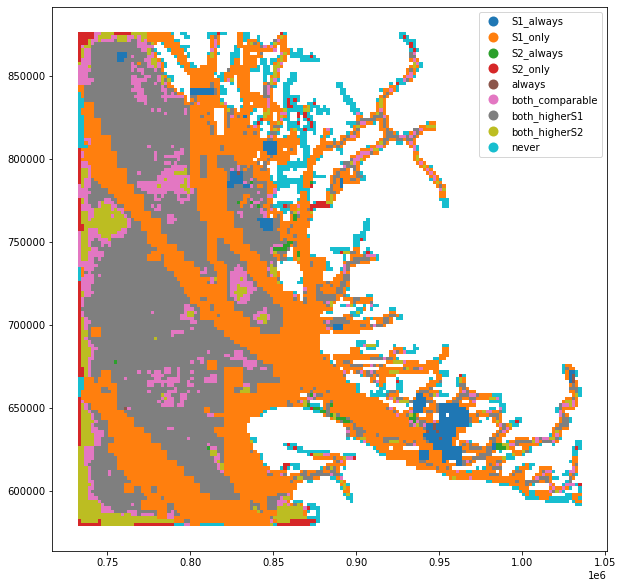

In [60]:
SCEN1_PATH = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario2'
SCEN2_PATH = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario3'
GRID_PATH = f'{SCEN1_PATH}/pu/pulayer.shp'
diff = diffMap(SCEN1_PATH,SCEN2_PATH, show_count =True)

### Plot Difference Map

<AxesSubplot:>

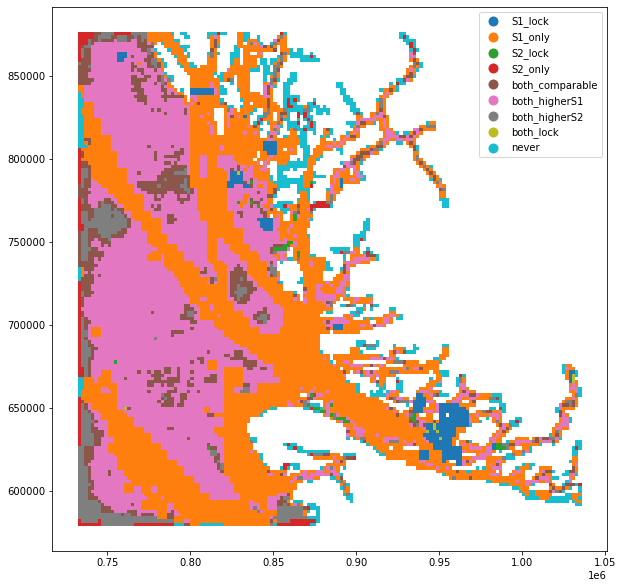

In [325]:
# Each category as solid color
plotDiffMap(diff,GRID_PATH, solid= True )

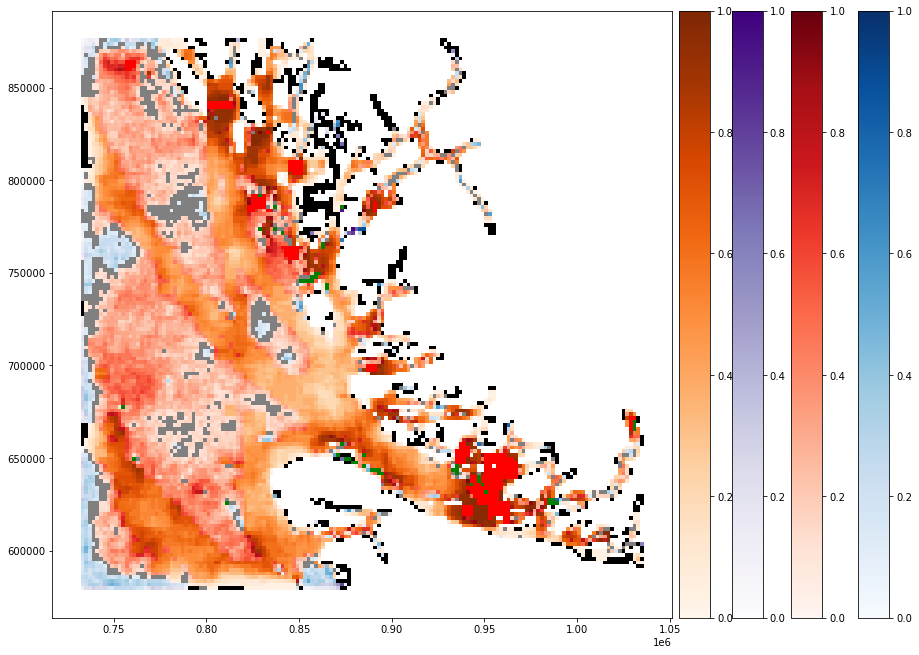

In [326]:
### Plot some categories as solid value and some as frequency 

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
ax1 = divider.append_axes("right", size="5%", pad=0.1)
ax2 = divider.append_axes("right", size="5%", pad=0.3)
ax3 = divider.append_axes("right", size="5%", pad=0.4)
ax4 = divider.append_axes("right", size="5%", pad=0.5)

diff[diff['planning_unit'].isin(never)].plot(ax = ax, color = 'black',legend=True, label = 'Never')
diff[diff['planning_unit'].isin(lock_both)].plot(ax = ax, color = 'yellow',legend =True, label='Always')
diff[diff['planning_unit'].isin(only_lock1)].plot(ax = ax, color = 'red',legend =True, label='Always S1')
diff[diff['planning_unit'].isin(only_lock2)].plot(ax = ax, color = 'purple',legend =True, label ='Always S2')
diff[diff['planning_unit'].isin(only1)].plot(ax = ax, column = 'diff',cmap = 'Oranges',vmin=0, vmax=1, legend= True, cax=ax1)
diff[diff['planning_unit'].isin(only2)].plot(ax = ax, column = 'diff_abs',cmap = 'Purples',vmin=0, vmax=1,legend=True,cax=ax2)
diff[diff['planning_unit'].isin(both_comparable)].plot(ax = ax, color = 'gray',legend = True)
diff[diff['planning_unit'].isin(both_higherS1)].plot(ax = ax, column = 'diff',cmap = 'Reds',vmin=0, vmax=1,legend=True,cax=ax3)
diff[diff['planning_unit'].isin(both_higherS2)].plot(ax = ax, column = 'diff_abs', cmap= 'Blues',vmin=0, vmax=1,legend=True,cax=ax4)
diff[diff['planning_unit'].isin(lock2)].plot(ax = ax, color = 'green')
plt.show()